# Bus Stops optimisation in Paris

Aiming at finding optimal bus stops for the city of Paris in regard to the RATP stations stops

RATP stations data : https://dataratp.opendatasoft.com/explore/dataset/positions-geographiques-des-stations-du-reseau-ratp/

RATP stations annual visitors : https://dataratp.opendatasoft.com/explore/dataset/trafic-annuel-entrant-par-station-du-reseau-ferre-2018/

## Imports

In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import osmnx as ox
import networkx as nx
import geopandas
from sklearn.cluster import DBSCAN

## Datasets

In [162]:
# Paris streets graph
G = ox.graph_from_place('Paris, France', network_type='drive')

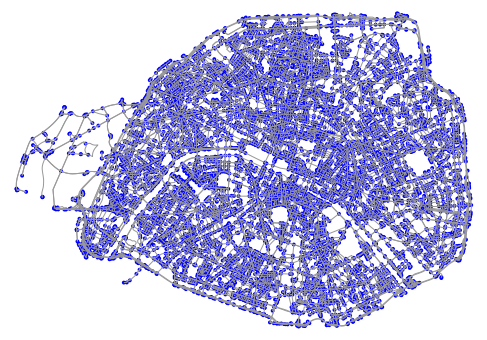

In [333]:
fig, ax = ox.plot_graph(G,node_color='blue')

getting the nodes

In [164]:
paris_gdf , _= ox.graph_to_gdfs(G)
paris_gdf

,y,x,osmid,highway,ref,geometry
5509971973,48.865456,2.391081,5509971973,NaN,NaN,POINT (2.39108 48.86546)
166297606,48.816421,2.360142,166297606,NaN,NaN,POINT (2.36014 48.81642)
271450120,48.875688,2.277891,271450120,NaN,NaN,POINT (2.27789 48.87569)
116129800,48.844563,2.287032,116129800,NaN,NaN,POINT (2.28703 48.84456)
116129802,48.843989,2.288553,116129802,NaN,NaN,POINT (2.28855 48.84399)
...,...,...,...,...,...,...
94142447,48.876005,2.368349,94142447,traffic_signals,NaN,POINT (2.36835 48.87600)
21659631,48.838379,2.353684,21659631,NaN,NaN,POINT (2.35368 48.83838)
21659629,48.837835,2.352156,21659629,NaN,NaN,POINT (2.35216 48.83783)
299270133,48.879638,2.340674,299270133,NaN,NaN,POINT (2.34067 48.87964)


In [165]:
# RATP stations dataframe
ratp_stations_df = pd.read_csv('Data/positions-geographiques-des-stations-du-reseau-ratp.csv', sep=';')
ratp_stations_df.head()

,ID,Name,Description,Coordinates
0,3677677,RUE DE LA FERME,ROND-POINT MARTIN LUTHER KING - 77258,"48.8359484574,2.62990289517"
1,3677688,COLLEGE LE LUZARD,COURS DES ROCHES - 77337,"48.8467902961,2.61369101"
2,3678812,ZONE TECHNIQUE,ROUTE DES ANNIVERSAIRES - 95527,"49.0119496186,2.5332905562"
3,3678816,ENTRETIEN NORD,ROUTE DE L'ARPENTEUR - 95527,"49.0114652199,2.51552950645"
4,3682876,AVRON,63 BOULEVARD ALSACE-LORRAINE - 94058,"48.8500655011,2.49939528589"


In [166]:
ratp_stations_df.dtypes

ID              int64
Name           object
Description    object
Coordinates    object
dtype: object

Let's keep only stations in Paris

In [167]:
ratp_stations_Paris = ratp_stations_df['Description'].apply(lambda x : True if '- 75' in x else False)
ratp_stations_Paris.sum()

6116

In [168]:
ratp_stations_Paris_df = ratp_stations_df.loc[ratp_stations_Paris,:]

In [169]:
ratp_stations_Paris_df.head()

,ID,Name,Description,Coordinates
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454"
35,7275123,GERARD DE NERVAL,AVENUE DE LA PORTE DE MONTMARTRE - 75118,"48.9007204012,2.33519629626"
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514"
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385"
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852"


Now, let's transform coordinates in geometry type

In [170]:
ratp_stations_Paris_df['x']=ratp_stations_Paris_df['Coordinates'].apply(lambda x : float(x.split(',')[1]))
ratp_stations_Paris_df['y']=ratp_stations_Paris_df['Coordinates'].apply(lambda x : float(x.split(',')[0]))
ratp_stations_Paris_df.head()

D:\Miniconda3\envs\ox\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Miniconda3\envs\ox\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Name,Description,Coordinates,x,y
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217
35,7275123,GERARD DE NERVAL,AVENUE DE LA PORTE DE MONTMARTRE - 75118,"48.9007204012,2.33519629626",2.335196,48.900720
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590


In [171]:
ratp_stations_Paris_gdf = geopandas.GeoDataFrame(ratp_stations_Paris_df,
                             geometry=geopandas.points_from_xy(ratp_stations_Paris_df.x, ratp_stations_Paris_df.y))
ratp_stations_Paris_gdf.head()

,ID,Name,Description,Coordinates,x,y,geometry
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217,POINT (2.44080 48.84422)
35,7275123,GERARD DE NERVAL,AVENUE DE LA PORTE DE MONTMARTRE - 75118,"48.9007204012,2.33519629626",2.335196,48.900720,POINT (2.33520 48.90072)
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806,POINT (2.34715 48.89481)
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334,POINT (2.35171 48.88133)
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590,POINT (2.35802 48.87559)


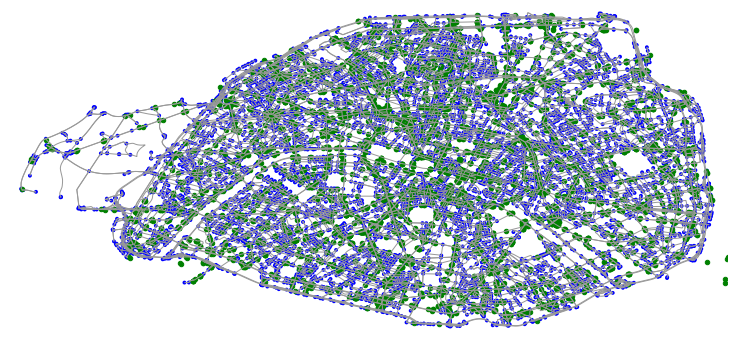

<Figure size 432x288 with 0 Axes>

In [334]:
ratp_stations_Paris_gdf['geometry'].plot(ax=ax, markersize=20, color='green')
fig

Let's delete nodes out of Paris we missed out

In [173]:
#To be done

We can now combine the nodes into one graph

In [174]:
G_new = G.copy()
nx.set_node_attributes(G_new, pd.Series('blue', index=paris_gdf.index), 'color')

In [175]:
G_new.add_nodes_from(ratp_stations_Paris_gdf.index,ratp=True, color='green')

In [176]:
nx.set_node_attributes(G_new, pd.Series(ratp_stations_Paris_gdf.x, index=ratp_stations_Paris_gdf.index).to_dict(), 'x')
nx.set_node_attributes(G_new, pd.Series(ratp_stations_Paris_gdf.y, index=ratp_stations_Paris_gdf.index).to_dict(), 'y')

In [177]:
paris_gdf2 , _= ox.graph_to_gdfs(G_new)
paris_gdf2

,y,x,osmid,color,highway,ref,ratp,geometry
5509971973,48.865456,2.391081,5.509972e+09,blue,NaN,NaN,NaN,POINT (2.39108 48.86546)
166297606,48.816421,2.360142,1.662976e+08,blue,NaN,NaN,NaN,POINT (2.36014 48.81642)
271450120,48.875688,2.277891,2.714501e+08,blue,NaN,NaN,NaN,POINT (2.27789 48.87569)
116129800,48.844563,2.287032,1.161298e+08,blue,NaN,NaN,NaN,POINT (2.28703 48.84456)
116129802,48.843989,2.288553,1.161298e+08,blue,NaN,NaN,NaN,POINT (2.28855 48.84399)
...,...,...,...,...,...,...,...,...
25313,48.852162,2.339706,NaN,green,NaN,NaN,True,POINT (2.33971 48.85216)
25315,48.835565,2.397499,NaN,green,NaN,NaN,True,POINT (2.39750 48.83556)
25316,48.861378,2.302112,NaN,green,NaN,NaN,True,POINT (2.30211 48.86138)
25318,48.819714,2.364081,NaN,green,NaN,NaN,True,POINT (2.36408 48.81971)


In [178]:
# verify we have the good amount of nodes
16182-10066

6116

All nodes are now in the same graph !

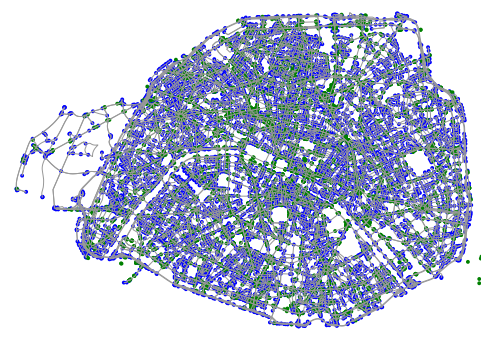

(<Figure size 952.984x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21ca94a0710>)

In [179]:
ox.plot_graph(G_new, node_color=paris_gdf2.color)

### Best nodes for a bus stop

Let's find the nodes with the most ratp nodes in a 200 meters range

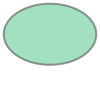

In [180]:
## need to project the node to use meters instead of longitude and latitude
projected_point, projection_crs = ox.project_geometry(ratp_stations_Paris_gdf['geometry'].iloc[0])
projected_buffer = projected_point.buffer(200)
buffer, latlong_crs = ox.project_geometry(projected_buffer, crs=projection_crs, to_latlong=True)
buffer

the figure above represents the 200m circle projected on Earth (Ellispoid) at the latitudes and longitudes of Paris

In [181]:
#Find the number of ratp stations in the circle around the node
def intersect(node, radius=200):
    projected_node, projection_crs = ox.project_geometry(node)
    projected_zone = projected_node.buffer(radius)
    zone, _ = ox.project_geometry(projected_zone, crs=projection_crs, to_latlong=True)
    number = ratp_stations_Paris_gdf.intersects(zone)
    return number.sum()

In [182]:
paris_gdf['Close_ratp_stations'] = paris_gdf['geometry'].apply(lambda x : intersect(x, radius=200))

In [183]:
paris_gdf.sort_values('Close_ratp_stations', ascending=False)

,y,x,osmid,highway,ref,geometry,Close_ratp_stations
178764471,48.874829,2.326771,178764471,NaN,NaN,POINT (2.32677 48.87483),91
169320949,48.874182,2.326925,169320949,traffic_signals,NaN,POINT (2.32692 48.87418),89
169320939,48.874163,2.325795,169320939,traffic_signals,NaN,POINT (2.32579 48.87416),87
676821350,48.857239,2.347120,676821350,NaN,NaN,POINT (2.34712 48.85724),87
676890491,48.857291,2.346919,676890491,NaN,NaN,POINT (2.34692 48.85729),87
...,...,...,...,...,...,...,...
164336043,48.823999,2.307660,164336043,NaN,NaN,POINT (2.30766 48.82400),0
94117688,48.884346,2.391263,94117688,NaN,NaN,POINT (2.39126 48.88435),0
243352389,48.889322,2.387757,243352389,NaN,NaN,POINT (2.38776 48.88932),0
260424537,48.895775,2.341499,260424537,NaN,NaN,POINT (2.34150 48.89578),0


In [184]:
G_final = G.copy()

In [185]:
nx.set_node_attributes(G_final, pd.Series('blue', index=paris_gdf.index), 'color')
paris_gdf['color']='blue'

Let's change the color of nodes with more than 50 ratp stations in a radius of 200m in red

In [186]:
high_close_ratp_stations = paris_gdf.loc[paris_gdf['Close_ratp_stations']>=50]
high_close_ratp_stations.head()

,y,x,osmid,highway,ref,geometry,Close_ratp_stations,color
361091,48.874814,2.357383,361091,traffic_signals,NaN,POINT (2.35738 48.87481),63,blue
361100,48.876362,2.355974,361100,traffic_signals,NaN,POINT (2.35597 48.87636),65,blue
361102,48.878524,2.354064,361102,NaN,NaN,POINT (2.35406 48.87852),52,blue
676890491,48.857291,2.346919,676890491,NaN,NaN,POINT (2.34692 48.85729),87,blue
676890544,48.857892,2.347183,676890544,traffic_signals,NaN,POINT (2.34718 48.85789),64,blue


In [187]:
paris_gdf['color'][high_close_ratp_stations.index] = 'red'

D:\Miniconda3\envs\ox\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
nx.set_node_attributes(G_final, pd.Series('red', index=high_close_ratp_stations.index), 'color')

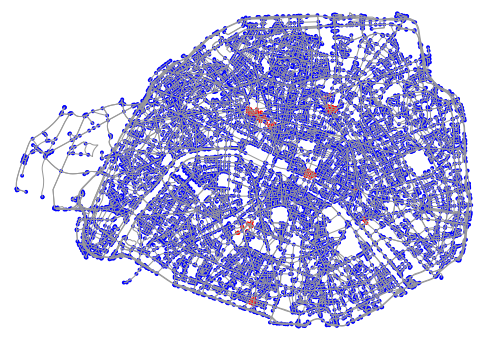

(<Figure size 952.984x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21ca95bea90>)

In [189]:
ox.plot_graph(G_final, node_color=paris_gdf.color)

5 or 6 main places seem to have good transport links and might be suitable places for bus stops !

However, until now only the number of stations around a node was taken into account and not the amount of possible clients the transports could bring. Let's check if we could have this information

## Using the traffic for each ratp station

The traffic in every ratp station has to be taken into account to find more accurately the best nodes !

In [230]:
ratp_traffic_df = pd.read_csv('Data/trafic-annuel-entrant-par-station-du-reseau-ferre-2018.csv', sep=';')
# keep only stations in Paris
ratp_traffic_df = ratp_traffic_df.loc[ratp_traffic_df['Ville'] == 'Paris']
ratp_traffic_df.head()

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,31,Métro,LA MOTTE-PICQUET-GRENELLE,7959759,6,8,10,NaN,NaN,Paris,15.0
3,241,Métro,PORTE DE CHARENTON,2262053,8,NaN,NaN,NaN,NaN,Paris,12.0
4,174,Métro,RUE DE LA POMPE,3241496,9,NaN,NaN,NaN,NaN,Paris,16.0
10,4,Métro,MONTPARNASSE-BIENVENUE,30646580,4,6,12,13.0,NaN,Paris,14.0
11,173,Métro,QUAI DE LA GARE,3252321,6,NaN,NaN,NaN,NaN,Paris,13.0


We need to find a way to match the stations names in the 2 ratp dataframes

In [231]:
ratp_stations_Paris_df.loc[ratp_stations_Paris_df['Name'].str.contains('LA MOTTE-PICQUET-GRENELLE')]

,ID,Name,Description,Coordinates,x,y,geometry,Traffic


In [232]:
ratp_stations_Paris_df.loc[ratp_stations_Paris_df['Name'].str.contains('MOTTE')]

,ID,Name,Description,Coordinates,x,y,geometry,Traffic
2823,3749894,LA MOTTE PICQUET - GRENELLE,130 BOULEVARD DE GRENELLE - 75115,"48.8487674045,2.29814365747",2.298144,48.848767,POINT (2.29814 48.84877),3.982742e+06
14448,3749893,LA MOTTE PICQUET - GRENELLE,63 AVENUE DE LA MOTTE PICQUET - 75115,"48.8494325987,2.29851084788",2.298511,48.849433,POINT (2.29851 48.84943),3.982742e+06


We can see the names from the 2 datasets are not consistent.

1. We will delete words like 'DE', 'LE', 'LA' and punctuation to test if relevant words are contained in the name
2. We will share the traffic among stations found

In [233]:
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('-', ' ')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('D\'', '')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace(' DE ', ' ')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace(' LE ', ' ')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace(' LA ', ' ')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('RUE ', '')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('RER', '')
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('BIENVENUE', '') #Montparnasse
ratp_traffic_df['Station'] = ratp_traffic_df['Station'].str.replace('CHATELET LES HALLES', 'CHATELET') # Chatelet

In [234]:
ratp_traffic_df.head()

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,31,Métro,LA MOTTE PICQUET GRENELLE,7959759,6,8,10,NaN,NaN,Paris,15.0
3,241,Métro,PORTE CHARENTON,2262053,8,NaN,NaN,NaN,NaN,Paris,12.0
4,174,Métro,POMPE,3241496,9,NaN,NaN,NaN,NaN,Paris,16.0
10,4,Métro,MONTPARNASSE,30646580,4,6,12,13.0,NaN,Paris,14.0
11,173,Métro,QUAI GARE,3252321,6,NaN,NaN,NaN,NaN,Paris,13.0


In [235]:
ratp_traffic_df['Name_words'] = ratp_traffic_df['Station'].str.split()

Let's now find how many stations are matching the name of the stations from the traffic dataset

In [236]:
def is_matching_station(name_words, station_name):
    for i in name_words:
        if i not in station_name:
            return False
    return True


def find_matching_stations(name_words, stations):
    '''
    Stations is the ratp_stations_Paris_df[['ID, 'name']]
    '''
    count = 0
    matching_stations = []
    index = 0
    for station in stations['Name']:
        if is_matching_station(name_words, station):
            count += 1
            matching_stations.append(stations.iloc[index, 0])
        index += 1
    return count, matching_stations
        

In [237]:
ratp_traffic_df['Num_stations'] = ratp_traffic_df['Name_words'].apply(lambda x: find_matching_stations(x, ratp_stations_Paris_df[['ID','Name']])[0])
ratp_traffic_df['ID_stations'] = ratp_traffic_df['Name_words'].apply(lambda x: find_matching_stations(x, ratp_stations_Paris_df[['ID','Name']])[1])

In [252]:
ratp_traffic_df.loc[ratp_traffic_df['Num_stations']==0]

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,Name_words,Num_stations,ID_stations
12,251,Métro,TRINITE ESTIENNE ORVES,2133878,12,NaN,NaN,NaN,NaN,Paris,9.0,"[TRINITE, ESTIENNE, ORVES]",0,[]
34,278,Métro,SEGUR,1605135,10,NaN,NaN,NaN,NaN,Paris,15.0,[SEGUR],0,[]
44,185,Métro,CORENTIN CARIOU,3023221,7,NaN,NaN,NaN,NaN,Paris,19.0,"[CORENTIN, CARIOU]",0,[]
63,11,RER,SAINT MICHEL NOTRE DAME,7247647,B,NaN,NaN,NaN,NaN,Paris,NaN,"[SAINT, MICHEL, NOTRE, DAME]",0,[]
72,285,Métro,CAMPO FORMIO,1369978,5,NaN,NaN,NaN,NaN,Paris,13.0,"[CAMPO, FORMIO]",0,[]
85,201,Métro,CORVISART,2819792,6,NaN,NaN,NaN,NaN,Paris,13.0,[CORVISART],0,[]
132,145,Métro,ALEXANDRE DUMAS,3668682,2,NaN,NaN,NaN,NaN,Paris,11.0,"[ALEXANDRE, DUMAS]",0,[]
152,228,Métro,TELEGRAPHE,2425536,11,NaN,NaN,NaN,NaN,Paris,20.0,[TELEGRAPHE],0,[]
180,271,Métro,SAINT SEBASTIEN FROISSART,1731645,8,NaN,NaN,NaN,NaN,Paris,3.0,"[SAINT, SEBASTIEN, FROISSART]",0,[]
188,61,Métro,COUR SAINT EMILION,6068940,14,NaN,NaN,NaN,NaN,Paris,12.0,"[COUR, SAINT, EMILION]",0,[]


We can see a few stations didn't match any from the other dataset. Since we managed to get all the main ones let's forget about these ones.

We can now divide the yearly traffic among all the matching stations

In [239]:
ratp_stations_Paris_df['Traffic'] = 0

D:\Miniconda3\envs\ox\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [240]:
traffic = ratp_traffic_df[['Trafic','Num_stations', 'ID_stations']]
for station in traffic.itertuples():
    if station.Num_stations > 0:
        to_add = station.Trafic/station.Num_stations
        for id in station.ID_stations:
            ratp_stations_Paris_df.loc[ratp_stations_Paris_df['ID']==id, ['Traffic']] += to_add



In [241]:
ratp_stations_Paris_df.head()

,ID,Name,Description,Coordinates,x,y,geometry,Traffic
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217,POINT (2.44080 48.84422),4.624373e+04
35,7275123,GERARD DE NERVAL,AVENUE DE LA PORTE DE MONTMARTRE - 75118,"48.9007204012,2.33519629626",2.335196,48.900720,POINT (2.33520 48.90072),0.000000e+00
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806,POINT (2.34715 48.89481),4.594697e+05
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334,POINT (2.35171 48.88133),1.401536e+06
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590,POINT (2.35802 48.87559),4.202361e+05


Now let's only keep stations with traffic > 0

In [242]:
ratp_stations_with_traffic = ratp_stations_Paris_df.loc[ratp_stations_Paris_df['Traffic']>0]
ratp_stations_with_traffic.shape

(3327, 8)

In [244]:
ratp_stations_with_traffic

,ID,Name,Description,Coordinates,x,y,geometry,Traffic
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217,POINT (2.44080 48.84422),4.624373e+04
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806,POINT (2.34715 48.89481),4.594697e+05
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334,POINT (2.35171 48.88133),1.401536e+06
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590,POINT (2.35802 48.87559),4.202361e+05
40,7275161,HOPITAL SAINT-VINCENT DE PAUL,76 AVENUE DENFERT-ROCHEREAU - 75114,"48.8373686296,2.33511711758",2.335117,48.837369,POINT (2.33512 48.83737),3.579516e+05
...,...,...,...,...,...,...,...,...
25296,4016357,LIEGE,57 RUE D'AMSTERDAM - 75108,"48.8805167838,2.32692588275",2.326926,48.880517,POINT (2.32693 48.88052),3.590736e+05
25299,3811223,GARE DU NORD,PISTE GARE ROUTIERE - 75110,"48.880830097,2.35731284118",2.357313,48.880830,POINT (2.35731 48.88083),1.401536e+06
25311,3813056,SAINT-FRANCOIS-XAVIER,FACE 65 RUE DE BABYLONE - 75107,"48.8518454423,2.31487890706",2.314879,48.851845,POINT (2.31488 48.85185),2.509446e+05
25313,3813066,SAINT-GERMAIN - ODEON,87 BOULEVARD SAINT-GERMAIN - 75106,"48.8521620799,2.33970608958",2.339706,48.852162,POINT (2.33971 48.85216),4.217982e+05


We can now use the traffic as weights in the graph

In [245]:
G_traffic = G.copy()

In [257]:
ratp_stations_traffic_gdf = geopandas.GeoDataFrame(ratp_stations_with_traffic,
                             geometry=geopandas.points_from_xy(ratp_stations_with_traffic.x, ratp_stations_with_traffic.y))
ratp_stations_traffic_gdf.head()

,ID,Name,Description,Coordinates,x,y,geometry,Traffic
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217,POINT (2.44080 48.84422),4.624373e+04
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806,POINT (2.34715 48.89481),4.594697e+05
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334,POINT (2.35171 48.88133),1.401536e+06
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590,POINT (2.35802 48.87559),4.202361e+05
40,7275161,HOPITAL SAINT-VINCENT DE PAUL,76 AVENUE DENFERT-ROCHEREAU - 75114,"48.8373686296,2.33511711758",2.335117,48.837369,POINT (2.33512 48.83737),3.579516e+05


In [258]:
#Find the traffic of ratp stations in the circle around the node
def intersect(node, radius=200):
    projected_node, projection_crs = ox.project_geometry(node)
    projected_zone = projected_node.buffer(radius)
    zone, _ = ox.project_geometry(projected_zone, crs=projection_crs, to_latlong=True)
    is_intersect = ratp_stations_traffic_gdf.intersects(zone)
    number = ratp_stations_traffic_gdf.loc[is_intersect,['Traffic']]
    return number.sum()

In [259]:
paris_traffic_gdf, _ = ox.graph_to_gdfs(G_traffic)
paris_traffic_gdf['traffic'] = 0

In [260]:
paris_traffic_gdf['traffic'] = paris_traffic_gdf['geometry'].apply(lambda x : intersect(x, radius=200))

In [261]:
paris_traffic_gdf.sort_values('traffic', ascending=False)

,y,x,osmid,highway,ref,geometry,traffic
367995,48.844498,2.372231,367995,traffic_signals,NaN,POINT (2.37223 48.84450),7.113613e+07
153508229,48.844332,2.372447,153508229,traffic_signals,NaN,POINT (2.37245 48.84433),6.718412e+07
1376039426,48.845134,2.371535,1376039426,NaN,NaN,POINT (2.37153 48.84513),5.571994e+07
306092060,48.845672,2.372622,306092060,NaN,NaN,POINT (2.37262 48.84567),5.005876e+07
676890545,48.857724,2.347777,676890545,traffic_signals,NaN,POINT (2.34778 48.85772),4.912150e+07
...,...,...,...,...,...,...,...
21346784,48.854455,2.295765,21346784,NaN,NaN,POINT (2.29577 48.85446),0.000000e+00
21346783,48.854623,2.295505,21346783,NaN,NaN,POINT (2.29550 48.85462),0.000000e+00
21378258,48.854877,2.296380,21378258,NaN,NaN,POINT (2.29638 48.85488),0.000000e+00
36485568,48.856262,2.292922,36485568,traffic_signals,NaN,POINT (2.29292 48.85626),0.000000e+00


Now let's change the color of the 100 nodes with the highest yearly traffic in a 200m radius

In [265]:
high_traffic_ratp_stations = paris_traffic_gdf.sort_values('traffic', ascending=False).head(100)
paris_traffic_gdf['color'] = 'blue'
paris_traffic_gdf.loc[high_traffic_ratp_stations.index,['color']] = 'red'

In [270]:
#change the color attribute in the graph
nx.set_node_attributes(G_traffic, pd.Series(paris_traffic_gdf['color'], index=paris_traffic_gdf.index), 'color')

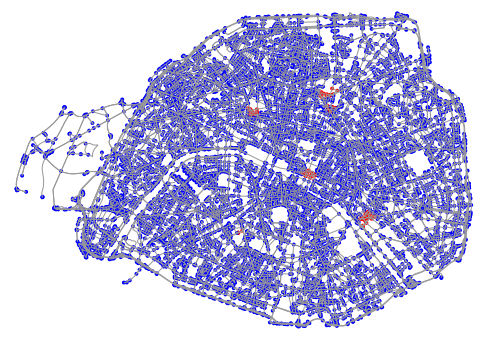

(<Figure size 952.984x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21cafd0d160>)

In [271]:
ox.plot_graph(G_traffic, node_color=paris_traffic_gdf.color)

Using the traffic makes Gare de Lyon much important while Porte d'Orléans completely disappeared from potential bus stops and Montparnasse looks much less important.

## Clustering the nodes to find the same kind of representation

Let's try to find clusters with high density of nodes close to each other

In [272]:
ratp_stations_Paris_gdf.head()

,ID,Name,Description,Coordinates,x,y,geometry
16,3685734,CHATEAU DE VINCENNES,PISTE GARE ROUTIERE - 75112,"48.8442170813,2.44079723454",2.440797,48.844217,POINT (2.44080 48.84422)
35,7275123,GERARD DE NERVAL,AVENUE DE LA PORTE DE MONTMARTRE - 75118,"48.9007204012,2.33519629626",2.335196,48.900720,POINT (2.33520 48.90072)
36,7275132,SIMPLON,46 BOULEVARD ORNANO - 75118,"48.8948064764,2.34715016514",2.347150,48.894806,POINT (2.34715 48.89481)
37,7275139,MAGENTA - MAUBEUGE - GARE DU NORD,140-142 BOULEVARD DE MAGENTA - 75110,"48.8813341943,2.35171250385",2.351713,48.881334,POINT (2.35171 48.88133)
38,7275143,GARE DE L'EST,74 BOULEVARD DE STRASBOURG - 75110,"48.8755903947,2.35801931852",2.358019,48.875590,POINT (2.35802 48.87559)


To cluster the nodes we have to project them from (longitude, latitude) to (x, y) in meters

In [282]:
projections = ratp_stations_Paris_gdf['geometry'].apply(lambda x: ox.project_geometry(x)[0])

In [288]:
nodes = pd.DataFrame(columns=('X', 'Y'))

In [291]:
nodes['X']=projections.apply(lambda x: x.x)
nodes['Y']=projections.apply(lambda x: x.y)
nodes.head()

,X,Y
16,458971.176641,5.410289e+06
35,451278.154359,5.416632e+06
36,452148.574381,5.415967e+06
37,452470.207240,5.414467e+06
38,452927.205020,5.413825e+06


We should scale X, Y before clustering but to keep the meter as a dimension we will only substract the mean from X and Y.

This will allow us to use an epsilon in meters when using DBSCAN

In [294]:
nodes['X'] = nodes['X'] - nodes['X'].mean()
nodes['Y'] = nodes['Y'] - nodes['Y'].mean()
nodes.head()

,X,Y
16,7321.087903,-1752.630986
35,-371.934380,4590.692563
36,498.485642,3925.695541
37,820.118502,2425.226788
38,1277.116281,1782.812365


Now let's try clustering with a DBSCAN to find high density zones in Paris (at least 50 stations in a 200 meters radius)

In [344]:
dbscan = DBSCAN(eps=200, min_samples=50, metric='euclidean')

In [345]:
dbscan.fit(nodes)

DBSCAN(algorithm='auto', eps=200, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=50, n_jobs=None, p=None)

In [346]:
nodes['Cluster'] = dbscan.labels_
nodes['Cluster'].max()

6

Let's plot those clusters

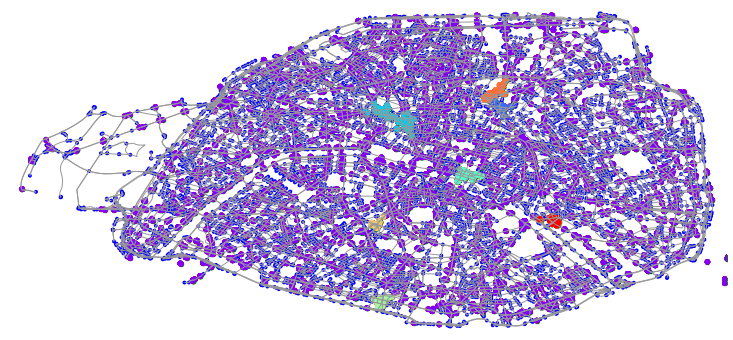

<Figure size 432x288 with 0 Axes>

In [363]:
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize()
ratp_stations_Paris_gdf['geometry'].plot(ax=ax, markersize=20, color=cmap(norm(nodes.Cluster.values)))
fig

We managed to find the 6 clusters we found previously using DBSCAN !